In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
import spectral
from numpy import linalg as LA
import time
import matplotlib.animation as animation
import matplotlib.colors
from IPython.display import HTML

\begin{aligned}
    \frac{\partial\phi}{\partial t} = \left(\nabla\cdot\frac{\nabla\phi}{|\nabla\phi|}\right)\cdot |\nabla\phi|
\end{aligned}

\begin{align*}
    \nabla \phi &= (\phi_x, \phi_y)
    \\|\nabla \phi| &= (\phi_x^2+\phi_y^2)^{1/2} 
    \\\frac{\nabla\phi}{|\nabla\phi|} &= \left(\frac{\phi_x}{(\phi_x^2+\phi_y^2)^{1/2} },\frac{\phi_y}{(\phi_x^2+\phi_y^2)^{1/2} }\right)
    \\\nabla\cdot\frac{\nabla\phi}{|\nabla\phi|} &= \frac{\phi_{xx}\cdot(\phi_x^2+\phi_y^2)^{1/2} - \phi_x\cdot\frac{\partial}{\partial x}(\phi_x^2+\phi_y^2)^{1/2}  + \phi_{yy}\cdot(\phi_x^2+\phi_y^2)^{1/2} - \phi_y\cdot\frac{\partial}{\partial y}(\phi_x^2+\phi_y^2)^{1/2}}{\phi_x^2+\phi_y^2}
\end{align*}

note that
\begin{align*}
    \frac{\partial}{\partial x}(\phi_x^2+\phi_y^2)^{1/2} &= \frac{1}{2}\cdot (\phi_x^2+\phi_y^2)^{-1/2}\cdot (2\phi_x\phi_{xx}+2\phi_y\phi_{xy})
    \\\frac{\partial}{\partial y}(\phi_x^2+\phi_y^2)^{1/2} &= \frac{1}{2}\cdot (\phi_x^2+\phi_y^2)^{-1/2}\cdot (2\phi_x\phi_{xy}+2\phi_y\phi_{yy})
\end{align*}

we obtain
\begin{align*}
    \nabla\cdot\frac{\nabla\phi}{|\nabla\phi|} &= \frac{(\phi_{xx}+\phi_{yy})\cdot(\phi_x^2+\phi_y^2)^{1/2} - (\phi_x^2+\phi_y^2)^{-1/2}\cdot(\phi_x^2\phi_{xx}+2\phi_x\phi_y\phi_{xy}+\phi_y^2\phi_{yy})}{\phi_x^2+\phi_y^2}
\end{align*}

and 
\begin{align*}
    \left(\nabla\cdot\frac{\nabla\phi}{|\nabla\phi|}\right)\cdot|\nabla\phi| &= \phi_{xx}+\phi_{yy}- \frac{\phi_x^2\phi_{xx}+2\phi_x\phi_y\phi_{xy}+\phi_y^2\phi_{yy}}{\phi_x^2+\phi_y^2}
\end{align*}

Thus the equation could be rewritten as
\begin{align*}
    \phi_t - \phi_{xx} - \phi_{yy} &= -\frac{\phi_x^2\phi_{xx}+2\phi_x\phi_y\phi_{xy}+\phi_y^2\phi_{yy}}{\phi_x^2+\phi_y^2}
\end{align*}

In [612]:
# set up the grid and resolution
N = 256
# x_basis = spectral.Fourier(N,(0,1000))
# y_basis = spectral.Chebyshev(N,(0,1000))
x_basis = spectral.Fourier(N,(0,2*np.pi))
y_basis = spectral.Chebyshev(N,(0,2*np.pi))
u = spectral.Field([x_basis, y_basis])
v = spectral.Field([x_basis, y_basis])
ux = spectral.Field([x_basis, y_basis])
uy = spectral.Field([x_basis, y_basis])
norm = spectral.Field([x_basis, y_basis])
uxx = spectral.Field([x_basis, y_basis])
uxy = spectral.Field([x_basis, y_basis])
uyy = spectral.Field([x_basis, y_basis])

u_RHS = spectral.Field([x_basis, y_basis])
uy_RHS = spectral.Field([x_basis, y_basis])

x = x_basis.grid()[:, None]
y = y_basis.grid()[None,:]
xm, ym = np.meshgrid(x.ravel(), y.ravel())

dt = 1e-2
s = 1
R = 1

In [613]:
problem = spectral.InitialValueProblem([u, uy], [u_RHS, uy_RHS], num_BCs=4)

In [614]:
# define the x, y derivative matrix and the convertion from T to U
L = y_basis.interval[1]-y_basis.interval[0]
diag = np.arange(N-1)+1
Dx = x_basis.derivative_matrix(np.float64)
# D = sparse.diags(diag, offsets=1) * (2/L)
D = y_basis.derivative_TU()

diag0 = np.ones(N)/2
diag0[0] = 1
diag2 = -np.ones(N-2)/2
# C = sparse.diags((diag0, diag2), offsets=(0,2))
C = y_basis.convert_TU()

Z = sparse.csr_matrix((N, N))

\begin{align}
    \partial_y \phi - \phi_y + \tau_1 U_{N-1} &= 0
    \\\partial_t \phi + \phi_{xx} + \partial_y \phi_y + \tau_2 U_{N-1} &= \frac{\phi_x^2\phi_{xx}+2\phi_x\phi_y\phi_{xy}+\phi_y^2\phi_{yy}}{\phi_x^2+\phi_y^2}
\end{align}

In [615]:
# define M and L in implicit explicit scheme
for sp in problem.subproblems:
    n = sp.wavenumbers[0]
    
    sp.M = sparse.csr_matrix((4*N+4, 4*N+4))
    sp.M[2*N:3*N, :N] = C
    sp.M[3*N:4*N, N:2*N] = C
    sp.M.eliminate_zeros()
    
#     L = sparse.bmat([[       D,        Z,   -C,    Z],
#                      [       Z,        D,    Z,   -C],
#                      [       Z,        Z,    D,    Z],
#                      [       Z,        Z,    Z,    D]])
    L = sparse.bmat([[       D,        Z,   -C,    Z],
                     [       Z,        D,    Z,   -C],
                     [ s*n**2*C,        Z,    -s*D,    Z],
                     [       Z,  s*n**2*C,    Z,    -s*D]])
    
    i = np.arange(N)
    BC_rows = np.zeros((4, 4*N))
    BC_rows[0, :N] = (-1)**i
    BC_rows[1, :N] = (+1)**i
    BC_rows[2, N:2*N] = (-1)**i
    BC_rows[3, N:2*N] = (+1)**i
    
    cols = np.zeros((4*N,4))
    cols[  N-1, 0] = 1
    cols[2*N-1, 1] = 1
    cols[3*N-1, 2] = 1
    cols[4*N-1, 3] = 1
    
    corner = np.zeros((4,4))
    
    sp.L = sparse.bmat([[L, cols],
                        [BC_rows, corner]])
    
    sp.L.eliminate_zeros()

/Users/yifanzhang/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [313]:
# plt.figure()
# plt.imshow(np.log(np.abs(problem.subproblems[0].L.A)))

In [616]:
LA.cond(problem.subproblems[0].L.A)

417.0358791758195

In [617]:
LA.cond(problem.subproblems[-1].L.A)

1358298.6006337136

In [618]:
ts = spectral.SBDF2(problem)

<IPython.core.display.Javascript object>


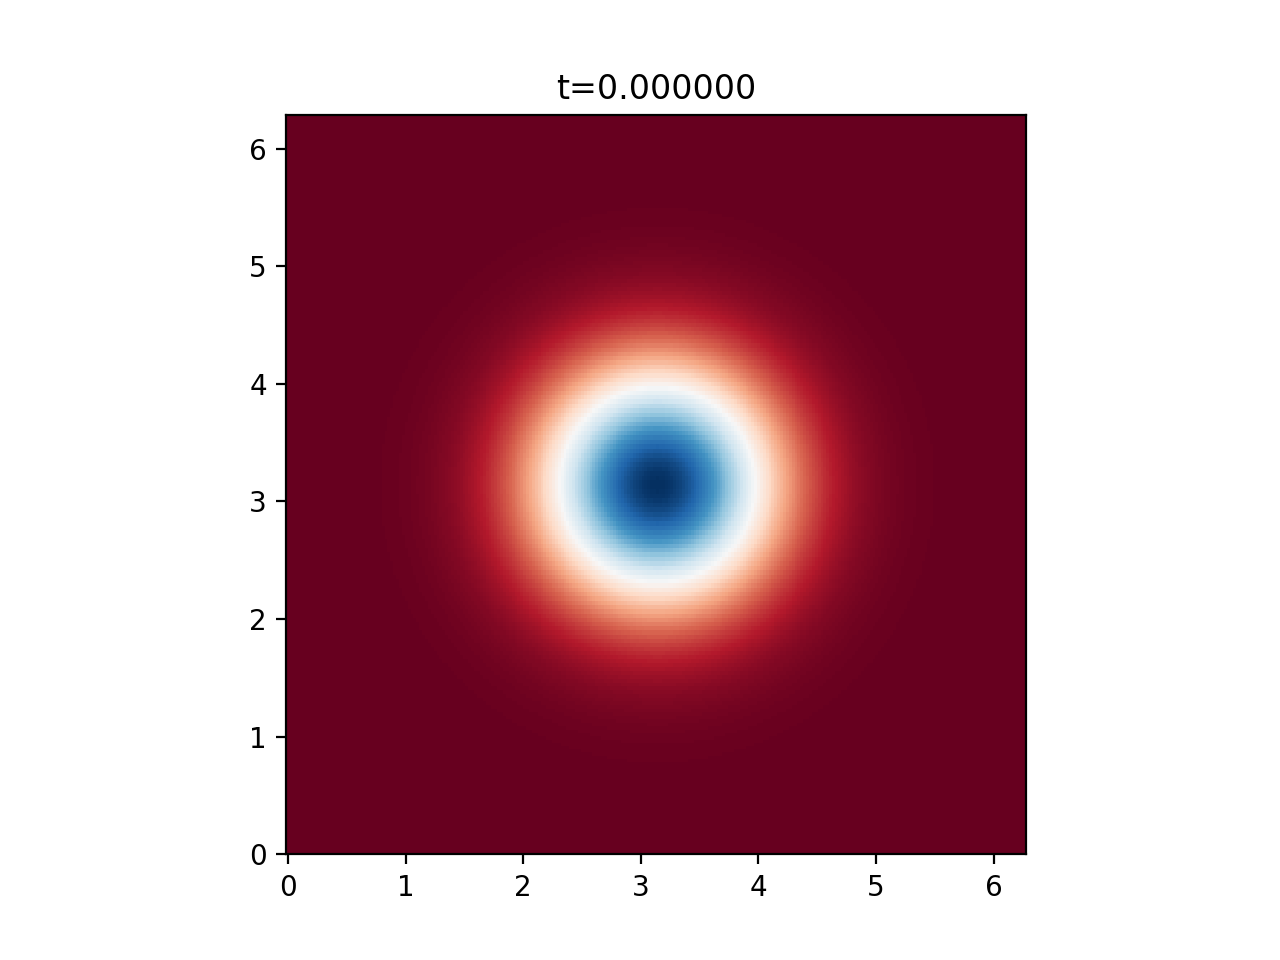

In [619]:
# initialize with a Gaussian peak at (pi,pi)
u.require_grid_space()
r = np.sqrt((x-np.pi)**2 + (y-np.pi)**2)
u.data = np.exp(-r**2)

# r = np.sqrt((x-500)**2 + (y-500)**2)
# u.data = np.exp(-1e-4*r**2)

# u.data = np.zeros((N,N))
# for i in range(N):
#     for j in range(N):
#         if ((x_basis.grid()[i]-5)**2+(y_basis.grid()[j]-5)**2 < 1):
#             u.data[i,j] = 1


fig = plt.figure()
ax = fig.subplots(1)
ax.pcolormesh(xm, ym, u.data.T, cmap='RdBu',vmax=1,shading='auto')
ax.set_aspect(1)
fig.canvas.draw()
title = plt.title('t=%f' %ts.time)

$u_y$ RHS is 
\begin{align*}
    \frac{\phi_x^2\phi_{xx}+2\phi_x\phi_y\phi_{xy}+\phi_y^2\phi_{yy}}{\phi_x^2+\phi_y^2}
\end{align*}

could be separated into $\phi_x^2\phi_{xx},\ 2\phi_x\phi_y\phi_{xy},\ \phi_y^2\phi_{yy},\ \phi_x^2+\phi_y^2$\
need to define $u_x,\ u_y,\ u_{xx},\ u_{xy},\ u_{yy}$

In [620]:
# begin the simulation, with frames saved
start=time.time()
u.require_grid_space()
frames_u = [u.data.copy()]
# fig = plt.figure()
# ax = fig.subplots(1)
# pcm = ax.pcolormesh(xm, ym, u.data.T, cmap='RdBu', vmax=1)
# ax.set_aspect(1)
# fig.canvas.draw()
# title = plt.title('t=%f' %ts.time)


BCs = np.array([0, 0, 0, 0])

for i in range(200):
#     print("step = ",i)
#     calculate ux
    ux.require_coeff_space()
    u.require_coeff_space()
    ux.data = Dx @ u.data
    ux.require_grid_space(scales=2)
#     calculate uy
    uy.require_coeff_space()
    u.require_coeff_space()
    uy.data = spectral.apply_matrix(D, u.data, axis=1)
    uy.data = spla.spsolve(C, uy.data.T).T
    uy.require_grid_space(scales=2)
    
#     calculate uxx
    uxx.require_coeff_space()
    u.require_coeff_space()
    uxx.data = Dx @ Dx @ u.data
    uxx.require_grid_space(scales=2)
    
#     calculate uxy
    uxy.require_coeff_space()
    uy.require_coeff_space()
    uxy.data = Dx @ uy.data
    uxy.require_grid_space(scales=2)
    
#     calculate uyy
    uyy.require_coeff_space()
    uy.require_coeff_space()
    uyy.data = spectral.apply_matrix(D, uy.data, axis=1)
    uyy.data = spla.spsolve(C, uyy.data.T).T
    uyy.require_grid_space(scales=2)
    

#     calculate norm = ux^2+uy^2
    norm.require_grid_space(scales=2)
    ux.require_grid_space(scales=2)
    uy.require_grid_space(scales=2)
    norm.data = ux.data**2 + uy.data**2

#     calculate RHS = ux^2*uxx + ux*uy*uxy + uy^2*uyy
    ux.require_grid_space(scales=2)
    uy.require_grid_space(scales=2)
    uxx.require_grid_space(scales=2)
    uxy.require_grid_space(scales=2)
    uyy.require_grid_space(scales=2)
    
    uy_RHS.require_grid_space(scales=2)
    uy_RHS.data = ux.data**2*uxx.data + ux.data*uy.data*uxy.data + uy.data**2*uyy.data
#     print("before division ux",np.max(np.abs(ux.data)))
#     print("before division uy",np.max(np.abs(uy.data)))
#     print("before division uxx",np.max(np.abs(uxx.data)))
#     print("before division uyy",np.max(np.abs(uyy.data)))
#     print("before division uxy",np.max(np.abs(uxy.data)))
#     print("before division RHS",np.max(np.abs(uy_RHS.data)))
    uy_RHS.data = -uy_RHS.data/(ux.data**2+uy.data**2)
#     uy_RHS.data = 0*u.data
#     print("norm max",np.max(np.abs((ux.data**2+uy.data**2))))
#     print("norm min",np.min(np.abs((ux.data**2+uy.data**2))))
#     print("after division RHS",np.max(np.abs(uy_RHS.data)))
    
    uy_RHS.require_coeff_space()
    uy_RHS.data = spectral.apply_matrix(C, uy_RHS.data, axis=1)

    ts.step(dt, BCs)
    
    u.require_grid_space()
    frames_u += [u.data[:-1,:-1].T.ravel()]
    if i % 5 == 0:
        print('iter = ', i)
#         title.set_text('t=' + str(round(ts.time,4)) + '\n' + 'iter =' + str(i))
#         u.require_grid_space()
#         frames_u += [u.data.copy()]
#         pcm.set_array(u.data[:-1,:-1].T.ravel())
#         fig.canvas.draw()
#     if i % 5 == 0:
#         title.set_text('t=%f' %ts.time)
#         u.require_grid_space()
#         a=np.copy(u.data)
#         a=np.where(a<0, 0, 1)
# #         plt.figure()
# #         plt.pcolormesh(xm, ym, a.data)
#         pcm.set_array(a[:-1,:-1].ravel())
#         fig.canvas.draw()
end = time.time()
print(end-start)

/Users/yifanzhang/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


iter =  0
iter =  5
iter =  10
iter =  15
iter =  20
iter =  25
iter =  30
iter =  35
iter =  40
iter =  45
iter =  50
iter =  55
iter =  60
iter =  65
iter =  70
iter =  75
iter =  80
iter =  85
iter =  90
iter =  95
iter =  100
iter =  105
iter =  110
iter =  115
iter =  120
iter =  125
iter =  130
iter =  135
iter =  140
iter =  145
iter =  150
iter =  155
iter =  160
iter =  165
iter =  170
iter =  175
iter =  180
iter =  185
iter =  190
iter =  195
15.428811073303223


In [621]:
# kick out the first frame
frames_u = frames_u[1:]

<IPython.core.display.Javascript object>


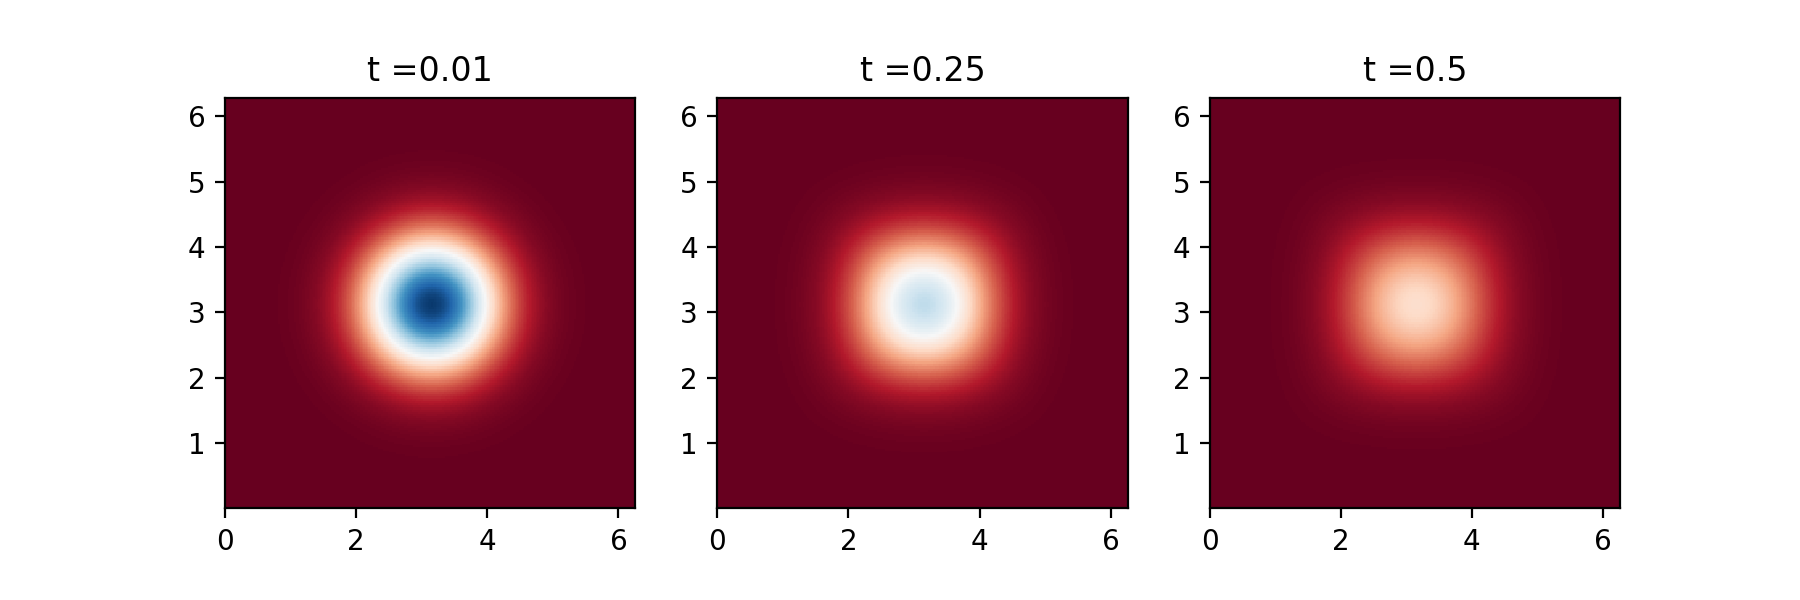

/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/3278789745.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1,cmap="RdBu")
/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/3278789745.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1,cmap="RdBu")
/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/327878

In [622]:
# plot at three different times along the simulation
fig = plt.figure(figsize=(9,3))

ax2 = fig.add_subplot(131)
pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1,cmap="RdBu")
ax2.set_title('t =' + str(round((0+1)*dt,2)))
ax2.set_box_aspect(1)
pcm_u.set_array(frames_u[0])

ax2 = fig.add_subplot(132)
pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1,cmap="RdBu")
ax2.set_title('t =' + str(round((24+1)*dt,2)))
ax2.set_box_aspect(1)
pcm_u.set_array(frames_u[24])

ax2 = fig.add_subplot(133)
pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1,cmap="RdBu")
ax2.set_title('t =' + str(round((49+1)*dt,2)))
ax2.set_box_aspect(1)
pcm_u.set_array(frames_u[49])
# fig.canvas.draw()
# plt.savefig("512X512_dt_1e-2_t_2_3.png")

<IPython.core.display.Javascript object>


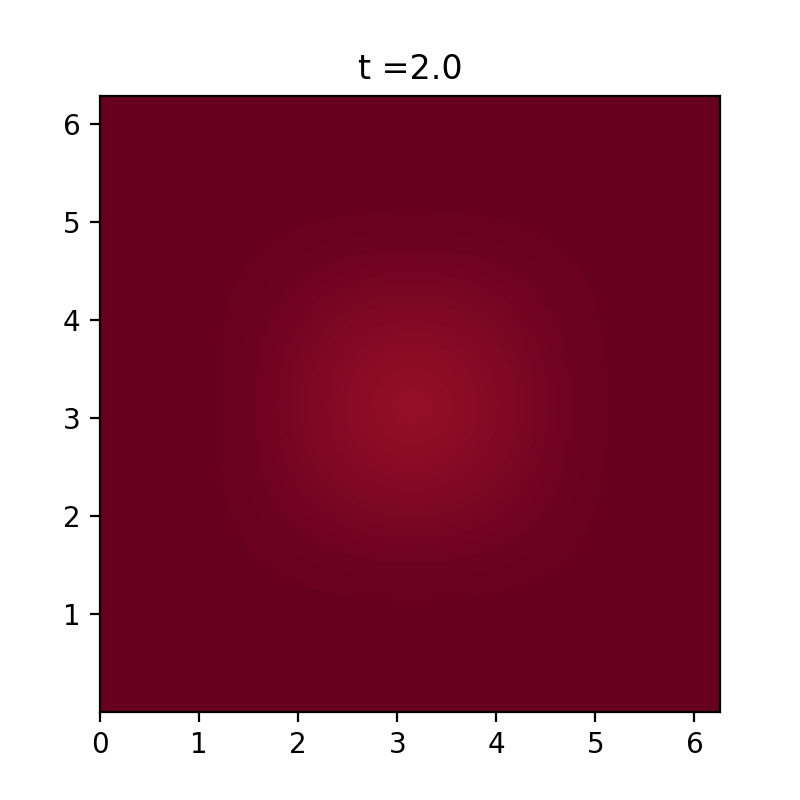

/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/3986359973.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_u = ax1.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1,cmap='RdBu')


In [623]:
# make a gif
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)


pcm_u = ax1.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1,cmap='RdBu')


def animate(i): 
    ax1.set_title('t =' + str(round((i+1)*dt,2)))
    pcm_u.set_array(frames_u[i])
    
anim = animation.FuncAnimation(fig, animate, frames = len(frames_u), repeat = False, interval = 33)
writergif = animation.PillowWriter()

# anim.save('256X256_dt_1e-2_t_2.gif',writer = writergif)

find the circle contour

In [624]:
p1=np.where(frames_u[0]<np.exp(-1), 0, 1)

In [625]:
frames_v=[p1]

In [626]:
for i in range(1,len(frames_u)):
    frames_v += [np.where(frames_u[i]<np.exp(-1), 0, 1)]

In [627]:
frames_v = frames_v[:60]

plot the contour at three timesteps

<IPython.core.display.Javascript object>


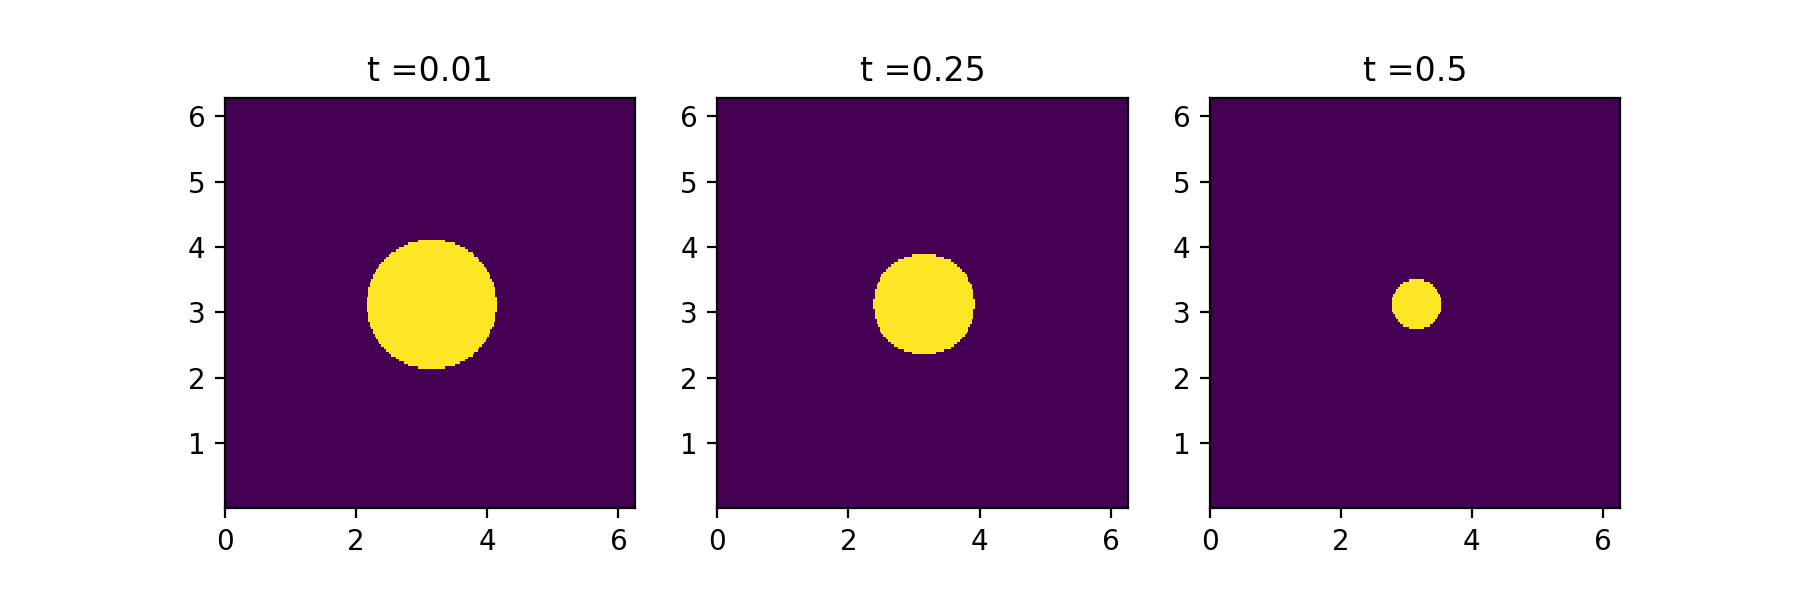

/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/1344635456.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1)
/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/1344635456.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1)
/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/1344635456.py:16: MatplotlibDe

In [628]:
fig = plt.figure(figsize=(9,3))

ax2 = fig.add_subplot(131)
pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1)
ax2.set_title('t =' + str(round((0+1)*dt,2)))
ax2.set_box_aspect(1)
pcm_u.set_array(frames_v[0])

ax2 = fig.add_subplot(132)
pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1)
ax2.set_title('t =' + str(round((24+1)*dt,2)))
ax2.set_box_aspect(1)
pcm_u.set_array(frames_v[24])

ax2 = fig.add_subplot(133)
pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1)
ax2.set_title('t =' + str(round((49+1)*dt,2)))
ax2.set_box_aspect(1)
pcm_u.set_array(frames_v[49])
# fig.canvas.draw()
# plt.savefig("C512X512_dt_1e-2_t_2_3.png")

<IPython.core.display.Javascript object>


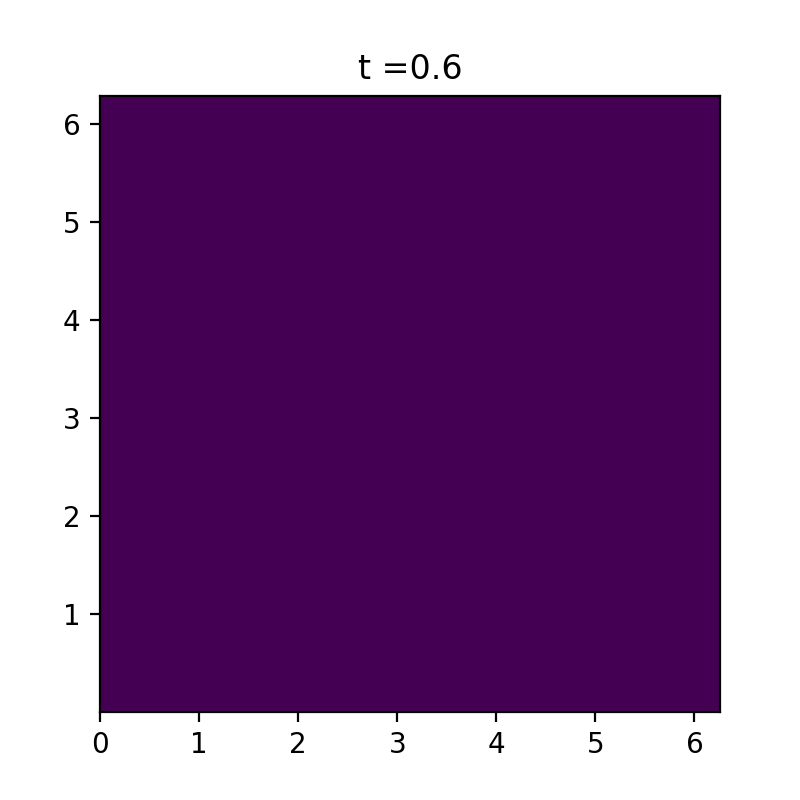

/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/2791419631.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1)


In [630]:
fig = plt.figure(figsize=(4,4))
ax2 = fig.add_subplot(111)
max_height = np.max([frames_v])

pcm_u = ax2.pcolormesh(xm,ym,u.data,vmin = 0,vmax = 1)

# ax1.set_xlabel('x')
# ax1.set_ylabel('y')

# ax1.set_title('u')

def init(): 
    pcm_u.set_array(frames_v[0])
def animate(i): 
    ax2.set_title('t =' + str(round((i+1)*dt,2)))
    pcm_u.set_array(frames_v[i])

anim = animation.FuncAnimation(fig, animate, frames = len(frames_v), repeat = False, interval = 200)
writergif = animation.PillowWriter(fps=3)
# anim.save('C512X512_dt_1e-2_t_2.gif',writer = writergif)

<IPython.core.display.Javascript object>


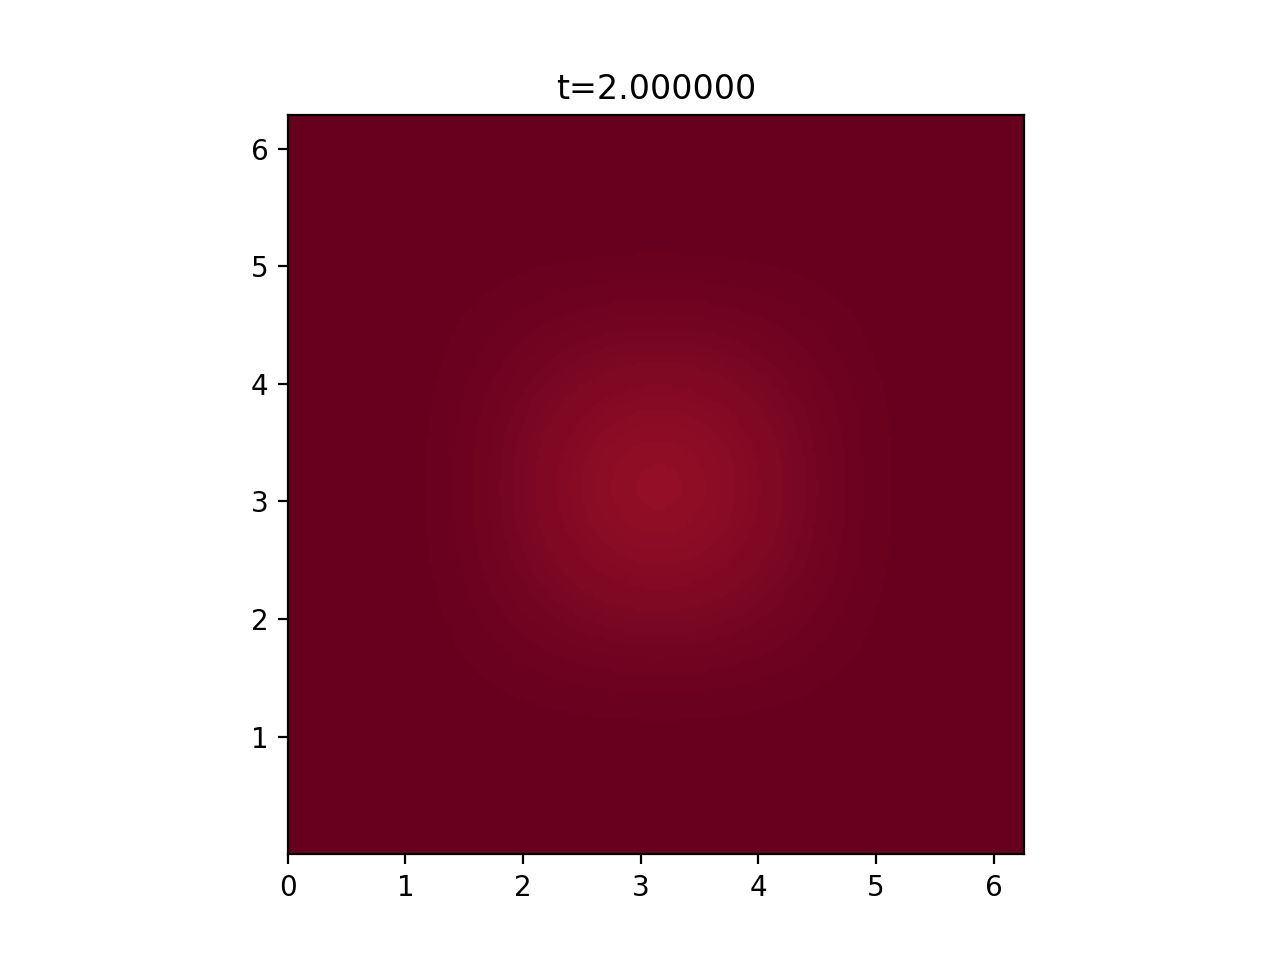

/var/folders/5w/21blhrg5025ftjzlgcn1v2kw0000gn/T/ipykernel_85800/3502123534.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(xm, ym, u.data.T, cmap='RdBu', vmax=1)


In [631]:
u.require_grid_space()
fig = plt.figure()
ax = fig.subplots(1)
pcm = ax.pcolormesh(xm, ym, u.data.T, cmap='RdBu', vmax=1)
ax.set_aspect(1)
fig.canvas.draw()
title = plt.title('t=%f' %ts.time)